## Введение

В данном ноутбуке проводится анализ датасета, содержащего следующие папки и файлы:

- images/ – изображения в формате .jpg (например, building-construction-building-site-constructing.jpg)
- labels/ – текстовые файлы с метками (например, construction-site-build-construction-work-159358.txt)
- meta-data/ – JSON-файлы с дополнительной информацией (например, building-construction-building-site-constructing.json)
- voc_labels/ – XML-файлы с разметкой в формате Pascal VOC (например, building-construction-building-site-constructing.xml)
- train_files.txt – список файлов для обучающей выборки
- val_files.txt – список файлов для валидационной выборки

**Цель анализа** – ознакомиться со структурой данных, проверить распределение классов, визуализировать образцы изображений с аннотациями и оценить качество разметки, чтобы в дальнейшем подготовить данные для обучения модели.

## 1. Определение путей и загрузка файлов

In [2]:
import os
import glob
import json
import random
import xml.etree.ElementTree as ET
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid")
import cv2

# Для работы с изображениями и вычисления хешей (при необходимости)
from PIL import Image
import imagehash

print("Библиотеки успешно импортированы.")


Библиотеки успешно импортированы.


In [5]:
import kagglehub

# Download latest version
data_path = kagglehub.dataset_download("mugheesahmad/sh17-dataset-for-ppe-detection")

print("Path to dataset files:", data_path)

Path to dataset files: C:\Users\Александр\.cache\kagglehub\datasets\mugheesahmad\sh17-dataset-for-ppe-detection\versions\1


## Введение
В данном ноутбуке проводится анализ датасета, содержащего следующие папки и файлы:

images/ – изображения в формате .jpg (например, building-construction-building-site-constructing.jpg)
labels/ – текстовые файлы с метками (например, construction-site-build-construction-work-159358.txt)
meta-data/ – JSON-файлы с дополнительной информацией (например, building-construction-building-site-constructing.json)
voc_labels/ – XML-файлы с разметкой в формате Pascal VOC (например, building-construction-building-site-constructing.xml)
train_files.txt – список файлов для обучающей выборки
val_files.txt – список файлов для валидационной выборки
Цель анализа – ознакомиться со структурой данных, проверить распределение классов (если оно доступно), визуализировать образцы изображений с аннотациями и оценить качество разметки, чтобы в дальнейшем подготовить данные для обучения модели.

In [15]:
# Пути к различным папкам
images_path = os.path.join(data_path, "images")
labels_path = os.path.join(data_path, "labels")
metadata_path = os.path.join(data_path, "meta-data")
voc_labels_path = os.path.join(data_path, "voc_labels")

# Пути к файлам разбиения на обучающую и валидационную выборки
train_files_path = os.path.join(data_path, "train_files.txt")
val_files_path = os.path.join(data_path, "val_files.txt")

# Получаем списки файлов
image_jpeg_files = glob.glob(os.path.join(images_path, "*.jpeg"))
image_jpg_files = glob.glob(os.path.join(images_path, "*.jpg"))
image_png_files = glob.glob(os.path.join(images_path, "*.png"))
label_files = glob.glob(os.path.join(labels_path, "*.txt"))
json_files  = glob.glob(os.path.join(metadata_path, "*.json"))
xml_files   = glob.glob(os.path.join(voc_labels_path, "*.xml"))

print("Общее количество изображений:", len(image_jpg_files) + len(image_jpeg_files) + len(image_png_files))
print("Количество изображений в формате .jpg:", len(image_jpg_files))
print("Количество изображений в формате .png:", len(image_png_files))
print("Количество изображений в формате .jpeg:", len(image_jpeg_files))
print("\nКоличество label файлов:", len(label_files))
print("Количество JSON метаданных:", len(json_files))
print("Количество VOC (XML) файлов:", len(xml_files))


Общее количество изображений: 8099
Количество изображений в формате .jpg: 4
Количество изображений в формате .png: 18
Количество изображений в формате .jpeg: 8077

Количество label файлов: 8099
Количество JSON метаданных: 8099
Количество VOC (XML) файлов: 8099


## 2. Анализ разбиения на обучающую и валидационную выборки

Файлы train_files.txt и val_files.txt содержат имена файлов, входящих в соответствующие выборки.

Имена файлов в этих списках соответствуют базовому имени файлов из папки images (например, building-construction-building-site-constructing).

In [16]:
def read_file_list(file_path):
    with open(file_path, 'r') as f:
        lines = f.read().splitlines()
    return lines

if os.path.exists(train_files_path):
    train_files = read_file_list(train_files_path)
    print("Размер обучающей выборки:", len(train_files))
else:
    print("Файл train_files.txt не найден.")

if os.path.exists(val_files_path):
    val_files = read_file_list(val_files_path)
    print("Размер валидационной выборки:", len(val_files))
else:
    print("Файл val_files.txt не найден.")


Размер обучающей выборки: 6479
Размер валидационной выборки: 1620


## 3. Визуализация образцов изображений

Для предварительного ознакомления выведем несколько случайных изображений из папки images.

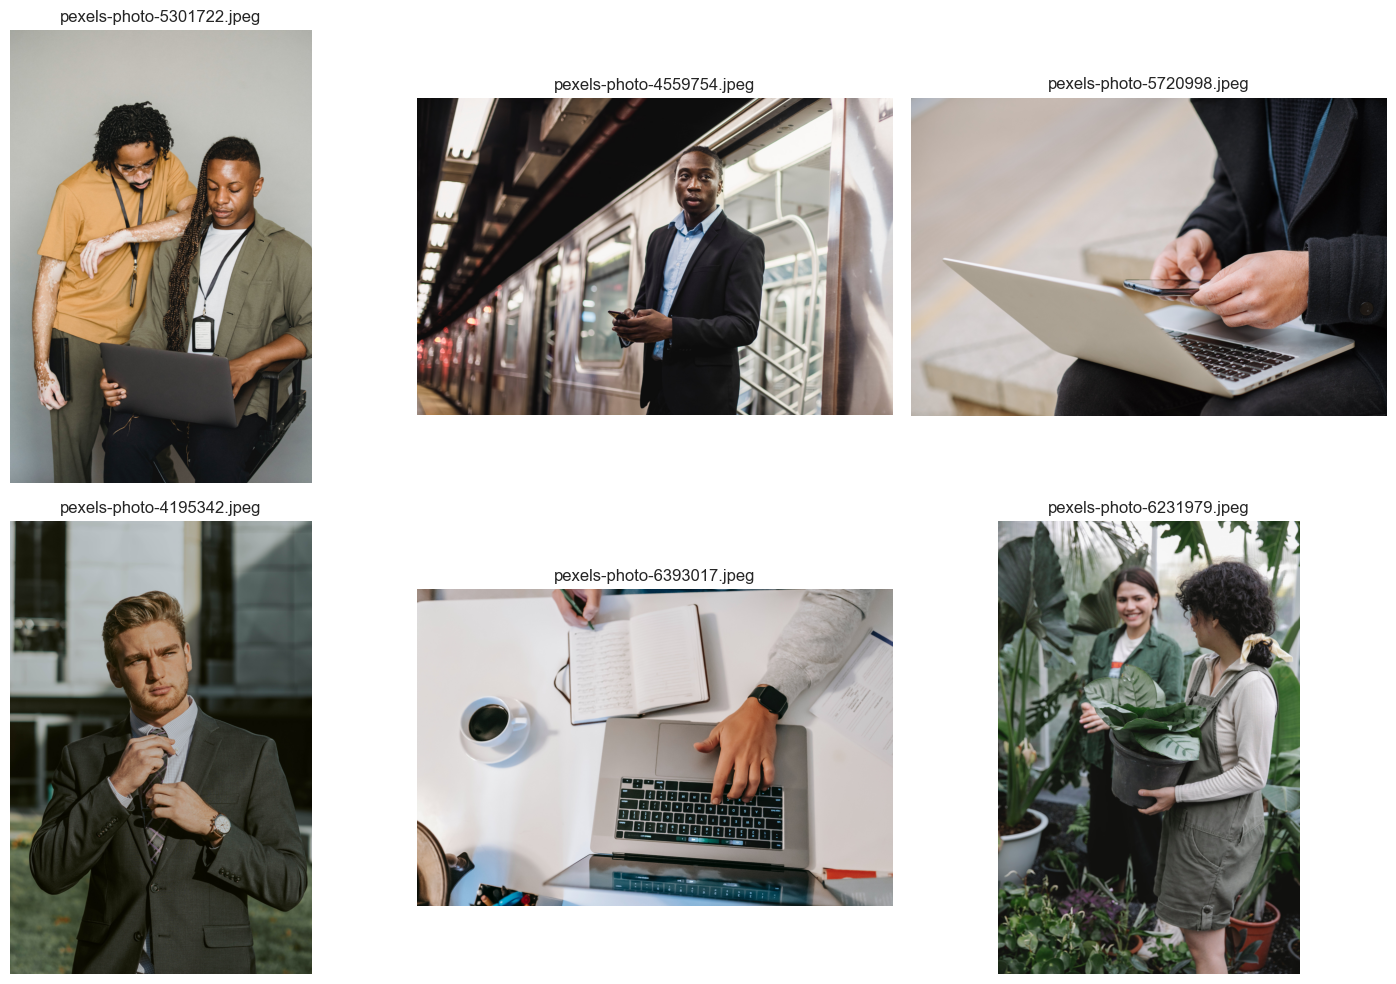

In [22]:
from PIL import Image

# Выбираем 6 случайных изображений
sample_img_files = random.sample(image_files, 6)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for ax, file in zip(axes, sample_img_files):
    try:
        # Загружаем изображение с помощью PIL
        img = Image.open(file)
        ax.imshow(img)
        ax.set_title(os.path.basename(file))
        ax.axis("off")
    except Exception as e:
        print(f"Не удалось загрузить {file}: {e}")

plt.tight_layout()
plt.show()


## 4. Анализ текстовых меток из папки labels

В папке labels содержатся .txt файлы с метками. В них записана информация об объектах на изображении (классы, координаты).

Каждая строка содержит класс и координаты.

Ниже приведён пример чтения содержимого одного файла:

In [23]:
# Чтение содержимого случайного .txt файла
sample_label_file = random.choice(label_files)
print("Имя файла:", os.path.basename(sample_label_file))
with open(sample_label_file, 'r') as f:
    label_content = f.read()
print("Содержимое файла:")
print(label_content)


Имя файла: pexels-photo-4489746.txt
Содержимое файла:
12 0.495693 0.476609 0.191285 0.105050
3 0.505954 0.489613 0.113504 0.080730
1 0.576767 0.475426 0.027616 0.029049
9 0.246770 0.538676 0.115024 0.093059
0 0.453002 0.665006 0.558905 0.669988
7 0.222194 0.512751 0.042564 0.146259
9 0.261338 0.398919 0.175576 0.135788



## 5. Анализ JSON файлов с метаданными из папки meta-data

JSON файлы содержат дополнительную информацию об изображении.

In [24]:
# Чтение содержимого случайного JSON файла
sample_json_file = random.choice(json_files)
print("Имя файла:", os.path.basename(sample_json_file))
with open(sample_json_file, 'r') as f:
    json_content = json.load(f)
print("Содержимое JSON:")
print(json.dumps(json_content, indent=4, ensure_ascii=False))


Имя файла: pexels-photo-9057191.json
Содержимое JSON:
{
    "id": 9057191,
    "width": 4561,
    "height": 2912,
    "url": "https://www.pexels.com/photo/a-person-wearing-face-mask-cutting-woods-9057191/",
    "photographer": "Gastón Mousist",
    "photographer_url": "https://www.pexels.com/@gaston-mousist-57404286",
    "photographer_id": 57404286,
    "avg_color": "#796544",
    "src": {
        "original": "https://images.pexels.com/photos/9057191/pexels-photo-9057191.jpeg",
        "large2x": "https://images.pexels.com/photos/9057191/pexels-photo-9057191.jpeg?auto=compress&cs=tinysrgb&dpr=2&h=650&w=940",
        "large": "https://images.pexels.com/photos/9057191/pexels-photo-9057191.jpeg?auto=compress&cs=tinysrgb&h=650&w=940",
        "medium": "https://images.pexels.com/photos/9057191/pexels-photo-9057191.jpeg?auto=compress&cs=tinysrgb&h=350",
        "small": "https://images.pexels.com/photos/9057191/pexels-photo-9057191.jpeg?auto=compress&cs=tinysrgb&h=130",
        "portrait":

## 6. Анализ аннотаций XML из папки voc_labels

XML файлы содержат информацию о расположении объектов на изображении. Ниже приведён пример парсинга XML файла с извлечением классов и координат ограничивающих рамок.

In [25]:
def parse_voc_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    objects = []
    for obj in root.findall('object'):
        obj_name = obj.find('name').text
        bndbox = obj.find('bndbox')
        bbox = {
            'xmin': int(bndbox.find('xmin').text),
            'ymin': int(bndbox.find('ymin').text),
            'xmax': int(bndbox.find('xmax').text),
            'ymax': int(bndbox.find('ymax').text)
        }
        objects.append({'class': obj_name, 'bbox': bbox})
    return objects

# Чтение содержимого случайного XML файла
sample_xml_file = random.choice(xml_files)
print("Имя файла:", os.path.basename(sample_xml_file))
objects = parse_voc_xml(sample_xml_file)
print("Объекты на изображении:")
for obj in objects:
    print(obj)


Имя файла: pexels-photo-5233285.xml
Объекты на изображении:
{'class': 'hands', 'bbox': {'xmin': 689, 'ymin': 412, 'xmax': 2361, 'ymax': 1777}}
{'class': 'tools', 'bbox': {'xmin': 0, 'ymin': 363, 'xmax': 2978, 'ymax': 2477}}
{'class': 'person', 'bbox': {'xmin': 0, 'ymin': 0, 'xmax': 2367, 'ymax': 1754}}


##  Анализ по классам, собирающий все аннотации в единый DataFrame

Сводная статистика по классам:


class
hands                15850
person               13802
head                 11985
face                  8950
ear                   7730
tools                 4647
shoes                 4560
gloves                2790
glasses               1945
helmet                 927
foot                   759
face-mask-medical      670
safety-vest            530
ear-mufs               318
safety-suit            240
medical-suit           157
face-guard             134
Name: count, dtype: int64

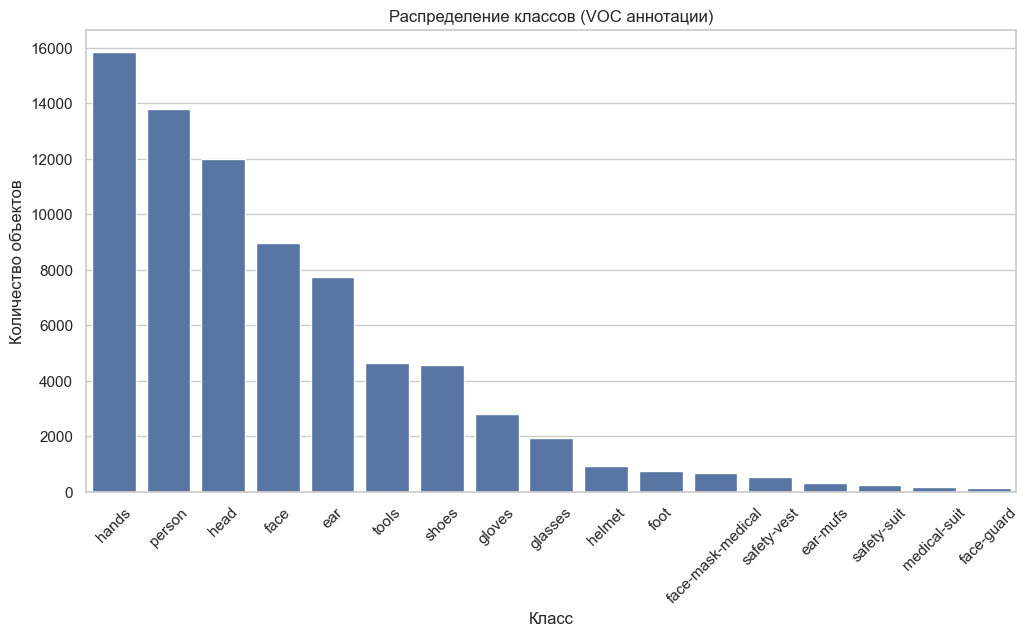

In [26]:
# Сбор статистики по классам из всех XML файлов
voc_data = []
for xml_file in xml_files:
    file_basename = os.path.splitext(os.path.basename(xml_file))[0]
    objects = parse_voc_xml(xml_file)
    for obj in objects:
        voc_data.append({
            'file': file_basename,
            'class': obj['class'],
            'xmin': obj['bbox']['xmin'],
            'ymin': obj['bbox']['ymin'],
            'xmax': obj['bbox']['xmax'],
            'ymax': obj['bbox']['ymax']
        })

voc_df = pd.DataFrame(voc_data)
print("Сводная статистика по классам:")
display(voc_df['class'].value_counts())

plt.figure(figsize=(12, 6))
sns.countplot(data=voc_df, x='class', order=voc_df['class'].value_counts().index)
plt.title("Распределение классов (VOC аннотации)")
plt.xlabel("Класс")
plt.ylabel("Количество объектов")
plt.xticks(rotation=45)
plt.show()


## 7. Визуализация аннотаций на изображениях

Чтобы убедиться в корректности разметки, выведем пример изображения с наложенными ограничивающими рамками (bounding boxes) из XML-аннотации.

Найден файл: C:\Users\Александр\.cache\kagglehub\datasets\mugheesahmad\sh17-dataset-for-ppe-detection\versions\1\images\pexels-photo-5710873.jpeg


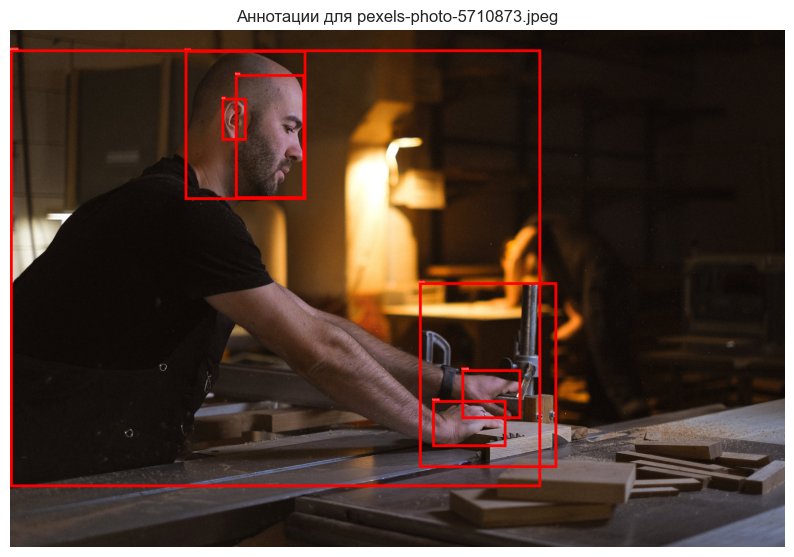

In [40]:
from PIL import Image, ImageDraw, ImageFont

def draw_voc_annotations_pil(image_file, voc_objects):
    try:
        img = Image.open(image_file).convert("RGB")
    except Exception as e:
        print(f"Не удалось загрузить {image_file}: {e}")
        return None

    draw = ImageDraw.Draw(img)
    try:
        font = ImageFont.truetype("arial.ttf", size=20)
    except Exception:
        font = ImageFont.load_default()

    for obj in voc_objects:
        bbox = obj['bbox']
        # Рисуем прямоугольник с увеличенной толщиной (width=4)
        draw.rectangle(
            [bbox['xmin'], bbox['ymin'], bbox['xmax'], bbox['ymax']],
            outline="red", width=20
        )
        # Получаем размер текста через getbbox
        text = obj['class']
        bbox_text = font.getbbox(text)
        text_width = bbox_text[2] - bbox_text[0]
        text_height = bbox_text[3] - bbox_text[1]
        text_size = (text_width, text_height)
        text_position = (bbox['xmin'], max(bbox['ymin'] - text_size[1], 0))
        # Рисуем заливку для текста
        draw.rectangle([text_position, (text_position[0] + text_size[0], text_position[1] + text_size[1])], fill="red")
        draw.text(text_position, text, fill="white", font=font)
    return img


# Выбираем случайный XML файл, парсим его аннотации
sample_xml = random.choice(xml_files)
sample_base = os.path.splitext(os.path.basename(sample_xml))[0]
voc_objs = parse_voc_xml(sample_xml)

# Пытаемся найти изображение по базовому имени с использованием функции поиска файла
sample_image_file = find_image_file(sample_base, images_path)
if sample_image_file:
    print("Найден файл:", sample_image_file)
else:
    print("Изображение не найдено для базового имени:", sample_base)

annotated_img = None
if sample_image_file:
    annotated_img = draw_voc_annotations_pil(sample_image_file, voc_objs)

if annotated_img is not None:
    plt.figure(figsize=(10, 8))
    plt.imshow(annotated_img)
    plt.title(f"Аннотации для {os.path.basename(sample_image_file)}")
    plt.axis("off")
    plt.show()
else:
    print("Не удалось загрузить изображение:", sample_image_file)


## 8. Метрики

### - обоснования почему выбрана одна метрика, а не другая + обзор метрик

Судя по тому, что можем увидеть в многочисленных статьях на тему обнаружения чего-либо, лучшим вариантом будет выбрать следующие метрики: 
1) Precision
Определяет долю правильно предсказанных объектов относительно всех предсказанных. Формально:

Precision = $\frac{TP}{TP + FP}$,

где:
- TP — количество истинно положительных предсказаний,
- FP — количество ложных срабатываний.  

Эта метрика важна, если необходимо минимизировать ложные срабатывания.

2) Recall
Показывает долю правильно предсказанных объектов относительно всех объектов, которые необходимо было обнаружить:


Recall = $\frac{TP}{TP + FN}$

где:
- FN — количество объектов, которые модель пропустила.  

Recall помогает оценить, насколько полно модель находит все интересующие объекты.

3) mAP

По mAP посмотрели подробнее: есть mAP@[0,5:0,95], например. Это среднее AP, вычисленное на нескольких порогах IoU (Intersection over Union) с шагом, например, 0,5. Такая метрика позволяет более точно оценить модель. Пока не до конца понимаем, как именно она работает и настраивается на живых примерах, но звучит модно. Можно попробовать


- **Precision** и **Recall** позволяют раздельно оценивать склонность модели к ложным срабатываниям и её способность находить все нужные объекты.
- **mAP** объединяет информацию от обеих метрик, усредняя их по классам и порогам IoU, что делает её особенно полезной для сравнения моделей в условиях, когда границы объектов могут варьироваться.

## 9. Данные и дизайн разметки

### - обоснования почему выбраны именно такие данные и именно такой дизайн разметки

### Обзор данных датасета SH17

Набор данных SH17 состоит из 8,099 изображений, собранных с сайта Pexels. Датасет включает 17 классов объектов, связанных с промышленными и производственными средами, и обладает следующими характеристиками:

#### Основные характеристики

- **Источник и сбор данных:**  
  Изображения были собраны с Pexels с использованием поисковых запросов, таких как *manufacturing worker*, *industrial worker*, *human worker*, *labor* и т.д. Это позволяет охватить широкий спектр промышленных операций и рабочих сцен.  

- **Количество изображений:**  
  В датасете содержится 8,099 изображений, что обеспечивает достаточную статистическую значимость для обучения моделей.

- **Качество и разрешение изображений:**  
  - Максимальное разрешение: 8192 х 5462 пикселей  
  - Минимальное разрешение: 1920 х 1002 пикселей  
  Высокое качество изображений позволяет детально анализировать мелкие объекты.

- **Аннотации и статистика объектов:**  
  - В среднем на одно изображение приходится 9.38 аннотаций.  
  - Датасет включает объекты малого размера, например, уши и наушники:
    - 39,764 аннотаций с площадью менее 1% от общей площади изображения.
    - 59,025 аннотаций с площадью менее 5% от общей площади изображения.

#### Форматы разметки

Датасет содержит три основные папки:
- **images:** Все исходные изображения.
- **labels:** Разметка в формате YOLO.
- **voc_labels:** Разметка в формате Pascal VOC.

Кроме того, имеются файлы:
- `train_files.txt` — список изображений для обучения.
- `val_files.txt` — список изображений для валидации.

#### Классы объектов

Разметка включает следующие 17 классов: Person, Head, Face, Glasses, Face-mask-medical, Face-guard, Ear, Earmuffs, Hands, Gloves, Foot, Shoes, Safety-vest, Tools, Helmet, Medical-suit, Safety-suit.

#### Цветовые характеристики:
   Высококачественные изображения с различными цветовыми характеристиками помогают модели адаптироваться к разнообразным условиям освещенности и фоновым особенностям. Анализ распределения цветов (например, с использованием средних значений $\mu$ и стандартных отклонений $\sigma$ по каждому каналу) позволяет применять нормализацию: $I_{\text{norm}} = \frac{I - \mu}{\sigma}$


#### Разнообразие данных:
 Изображения собраны из различных промышленных сред по всему миру, что минимизирует региональные или расовые смещения и делает модель более универсальной. При этом имеется значительное число изображений **не** принадлежащих промышленным средам. (видимо, для увеличения объема данных для классов head, face, person, hands, ear и тд)

## 10. Итоги анализа и дальнейшие шаги

**На данном этапе мы:**

- Ознакомились с основными компонентами датасета: изображения, текстовые метки, JSON метаданные и XML аннотации.
- Проанализировали распределение объектов по классам на основе XML разметки.
- Проверили разбиение данных на обучающую и валидационную выборки.
- Визуально проверили несколько примеров изображений с наложенной разметкой.

**Дальнейшие шаги:**

- Предобработка изображений (изменение размеров, нормализация).
- Интеграция информации из разных источников аннотаций (если требуется объединить текстовые метки, JSON и VOC).
- Построение обучающей выборки с учетом разбиения на train/val.
- Применение методов аугментации для повышения обобщающей способности модели.
- Обучение модели детекции объектов (например, с использованием архитектур YOLO, Faster R-CNN, EfficientDet и т.д.).